<a href="https://colab.research.google.com/github/sumanth-ds/Data_Science_Projects/blob/main/predicting_cab_confrmation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Model for Cab Comfirmation or Cancelled

<img src = "https://th.bing.com/th/id/OIP.EXlz2kq5t2vypezNejVXTAHaCz?rs=1&pid=ImgDetMain" />

# Problem Statment

The business problem tackled here is trying to improve customer service for YourCabs.com, a cab company in Bangalore.

The problem of interest is booking cancellations by the company due to the unavailability of a car. The challenge is that cancellations can occur very close to the trip start time, thereby causing passengers inconvenience.

The goal of the competition is to create a predictive model for classifying new bookings as to whether they will eventually get cancelled due to car unavailability


# Feature Name Meaning
  
  id - booking ID.

  user_id - the ID of the customer (based on mobile number).

  vehicle_model_id - vehicle model type.

  package_id - type of package (1=4hrs & 40kms, 2=8hrs & 80kms, 3=6hrs & 60kms, 4= 10hrs & 100kms, 5=5hrs & 50kms, 6=3hrs & 30kms, 7=12hrs & 120kms).

  travel_type_id - type of travel (1=long distance, 2= point to point, 3= hourly rental).

  from_area_id - unique identifier of area. Applicable only for point-to-point travel and packages.

  to_area_id - unique identifier of area. Applicable only for point-to-point travel.

  from_city_id - unique identifier of city.

  to_city_id - unique identifier of city (only for intercity).

  from_date - time stamp of requested trip start.

  online_booking - if booking was done on desktop website.

  mobile_site_booking - if booking was done on mobile website.

  booking_created - time stamp of booking.

  from_lat - latitude of from area.

  from_long - longitude of from area.

  to_lat - latitude of to area.

  to_long - longitude of to area.

  Car_Cancellation - whether the booking was cancelled (1) or not (0) due to unavailability of a car.


## Importing the requried packages

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import ConfusionMatrixDisplay , precision_score , recall_score , f1_score ,accuracy_score
from sklearn.linear_model import LogisticRegression
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle

## Loading the dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Projects/predicting_cab/YourCabs.csv")
data.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,01-01-2013 02:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,01-01-2013 03:30,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,01-01-2013 05:45,0,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0


## Split the dataset into train dataset and test dataset

In [ ]:
from sklearn.model_selection import train_test_split


x = data.drop(["Car_Cancellation"] , axis = 1)
y = data["Car_Cancellation"]

feature_train , target_train , feature_test , target_test = train_test_split(x , y , test_size = 0.3 , random_state = 42 , stratify = y)

In [ ]:
feature_train.reset_index(drop = True , inplace = True)
feature_test.reset_index(drop = True , inplace = True)
target_train.reset_index(drop = True , inplace = True)
target_test.reset_index(drop = True , inplace = True)


In [ ]:
feature_train.shape , feature_test.shape

((30401, 17), (30401,))

In [ ]:
target_train.shape , target_test.shape

((13030, 17), (13030,))

In [ ]:
# checking the data spliting in terms of percentage
feature_test.value_counts()/len(feature_test)*100 , target_test.value_counts()/len(target_test)*100

(0    92.789711
 1     7.210289
 Name: Car_Cancellation, dtype: float64,
 0    92.785879
 1     7.214121
 Name: Car_Cancellation, dtype: float64)

## Exploratory Data Analysis (EDA)

In [ ]:
feature_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30401 entries, 0 to 30400
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   30401 non-null  int64  
 1   user_id              30401 non-null  int64  
 2   vehicle_model_id     30401 non-null  int64  
 3   package_id           5285 non-null   float64
 4   travel_type_id       30401 non-null  int64  
 5   from_area_id         30342 non-null  float64
 6   to_area_id           24008 non-null  float64
 7   from_city_id         11404 non-null  float64
 8   to_city_id           1108 non-null   float64
 9   from_date            30401 non-null  object 
 10  online_booking       30401 non-null  int64  
 11  mobile_site_booking  30401 non-null  int64  
 12  booking_created      30401 non-null  object 
 13  from_lat             30338 non-null  float64
 14  from_long            30338 non-null  float64
 15  to_lat               24008 non-null 

In [ ]:
feature_train[feature_train.duplicated()]

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long


In [ ]:
feature_train.describe(exclude="object")

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long
count,30401.000000,30401.000000,30401.000000,5285.000000,30401.000000,30342.000000,24008.000000,11404.000000,1108.000000,30401.000000,30401.000000,30338.000000,30338.000000,24008.000000,24008.000000
mean,159219.360942,30740.002204,25.749054,2.051845,2.137364,712.811318,670.239753,14.928446,69.451264,0.354725,0.043288,12.982460,77.636270,13.026734,77.640921
std,15444.825570,10972.353946,26.815958,1.474602,0.437561,420.268919,400.562296,1.098723,49.870097,0.478438,0.203508,0.086157,0.059515,0.113563,0.064057
min,132512.000000,16.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,4.000000,0.000000,0.000000,12.776630,77.386930,12.776630,77.386930
25%,145741.000000,24644.000000,12.000000,1.000000,2.000000,393.000000,393.000000,15.000000,32.000000,0.000000,0.000000,12.926450,77.593661,12.951850,77.583432
50%,159237.000000,31605.000000,12.000000,2.000000,2.000000,590.000000,541.000000,15.000000,51.000000,0.000000,0.000000,12.967990,77.635750,12.984790,77.645120
75%,172609.000000,39183.000000,24.000000,2.000000,2.000000,1089.000000,1054.000000,15.000000,108.000000,1.000000,0.000000,13.007750,77.688900,13.199560,77.706880
max,185941.000000,48730.000000,91.000000,7.000000,3.000000,1403.000000,1403.000000,31.000000,203.000000,1.000000,1.000000,13.366072,77.786420,13.366072,77.786420


## Preprocessing

In [ ]:
# here id , user_id , vehicle_model_id are not need for this project so i drop the columns

droped_columns = ["id","user_id","vehicle_model_id"]

feature_train.drop(["id","user_id","vehicle_model_id"] , axis=1 , inplace = True)

In [ ]:
feature_train.isnull().sum()/len(data)*100

package_id             57.829661
travel_type_id          0.000000
from_area_id            0.135848
to_area_id             14.719901
from_city_id           43.740646
to_city_id             67.447215
from_date               0.000000
online_booking          0.000000
mobile_site_booking     0.000000
booking_created         0.000000
from_lat                0.145058
from_long               0.145058
to_lat                 14.719901
to_long                14.719901
dtype: float64

In [ ]:
# package_id , from_city_id , to_city_id  are the columns need to drop its contain more null values

feature_train.drop(["package_id" , "from_city_id" , "to_city_id" ] , axis = 1 , inplace = True)

droped_columns.extend(["package_id" , "from_city_id" , "to_city_id" ])

In [ ]:

def fillna_values(data):
  columns = data.columns
  for column in columns:
    if data[column].isnull().sum()>0:
      data[column].fillna(data[column].mode()[0], inplace = True)
  return data

feature_train = fillna_values(feature_train)
feature_train.isnull().sum()


# feature_train["to_area_id"].fillna(feature_train["to_area_id"].mode()[0],inplace = True)
# feature_train["from_lat"].fillna(feature_train["from_lat"].mode()[0], inplace = True)
# feature_train["from_long"].fillna(feature_train["from_long"].mode()[0],inplace = True)
# feature_train["to_lat"].fillna(feature_train["to_lat"].mode()[0] , inplace = True )
# feature_train["to_long"].fillna(feature_train["to_long"].mode[0],inplace = True)

travel_type_id         0
from_area_id           0
to_area_id             0
from_date              0
online_booking         0
mobile_site_booking    0
booking_created        0
from_lat               0
from_long              0
to_lat                 0
to_long                0
dtype: int64

In [ ]:
feature_train.head(1)

,travel_type_id,from_area_id,to_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long
0,3,1330.0,393.0,10-08-2013 09:15,0,0,10-08-2013 00:05,12.953434,77.70651,13.19956,77.70688


## Feature Selection

<ipython-input-16-bd8d4abb3cff>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(feature_train.corr(), annot = True , fmt = "0.2f" ,  )


<Axes: >

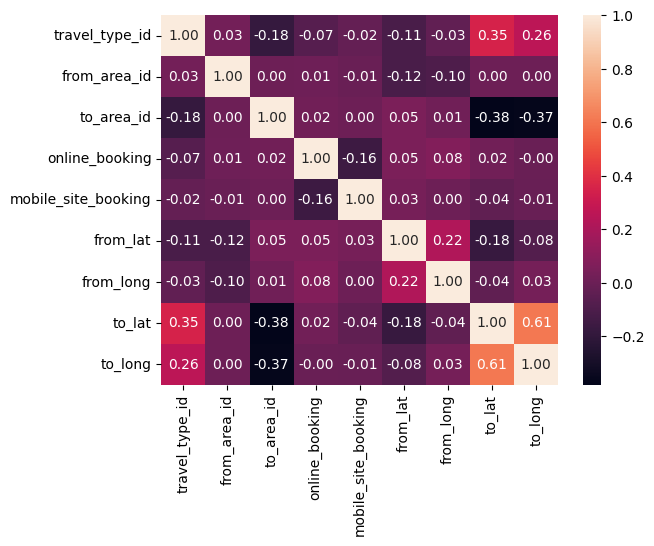

In [ ]:
sns.heatmap(feature_train.corr(), annot = True , fmt = "0.2f" ,  )

<Axes: >

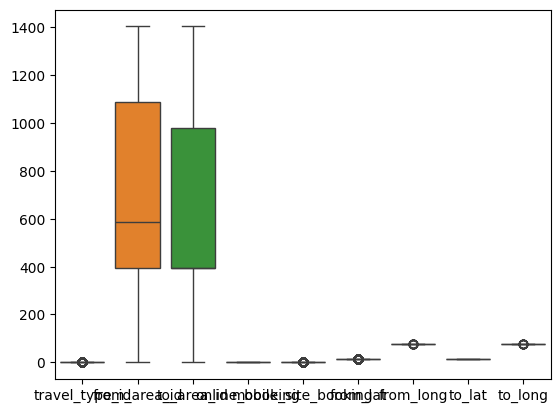

In [ ]:
sns.boxplot(feature_train)

In [ ]:
feature_train.head(1)

,travel_type_id,from_area_id,to_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long
0,3,1330.0,393.0,10-08-2013 09:15,0,0,10-08-2013 00:05,12.953434,77.70651,13.19956,77.70688


In [ ]:
def datetime_convert(date,*text):
  for column in text:
    date[column] = pd.to_datetime(date[column])
  return date

feature_train = datetime_convert(feature_train ,"from_date" ,"booking_created")
#feature_train["booking_created"] = datetime_convert(feature_train ,"booking_created")


In [ ]:
def duration(data , date1,date2):

  data["Duration"] = ((data[date1] - data[date2]).dt.floor("D")).astype(int)
  return data

feature_train = duration(feature_train , "from_date" , "booking_created" )
feature_train.head(1)

,travel_type_id,from_area_id,to_area_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Duration
0,3,1330.0,393.0,2013-10-08 09:15:00,0,0,2013-10-08 00:05:00,12.953434,77.70651,13.19956,77.70688,0


In [ ]:

def feature_engineering_data(data,text):
  data[text+"_"+"day"] = data[text].dt.day
  data[text+"_"+"month"] = data[text].dt.month
  data[text+"_"+"weekday"] = data[text].dt.weekday

  return data

feature_train =  feature_engineering_data(feature_train,"from_date")
# feature_train = pd.concat([feature_train ,train_date],axis =1)

feature_train.drop(["from_date"],axis = 1,  inplace  = True)

feature_train =feature_engineering_data(feature_train,"booking_created")

feature_train.drop([ "booking_created"],axis = 1,  inplace  = True)



# feature_train["booking_created"] = pd.to_datetime(feature_train["booking_created"])
# feature_train["from_date"] = pd.to_datetime(feature_train["from_date"])

# feature_train["day"] = feature_train["from_date"].dt.day
# feature_train["month"] = feature_train["from_date"].dt.month
# feature_train["weekday"] = feature_train["from_date"].dt.weekday



In [ ]:
feature_train.head()

,travel_type_id,from_area_id,to_area_id,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Duration,from_date_day,from_date_month,from_date_weekday,booking_created_day,booking_created_month,booking_created_weekday
0,3,1330.0,393.0,0,0,12.953434,77.70651,13.19956,77.70688,0,8,10,1,8,10,1
1,2,156.0,393.0,0,0,13.026220,77.70143,13.19956,77.70688,0,5,2,1,4,2,0
2,2,25.0,172.0,0,0,12.980590,77.57475,12.97091,77.63050,0,15,9,6,14,9,5
3,1,1396.0,393.0,0,0,13.199560,77.70688,13.19956,77.70688,0,25,10,4,25,10,4
4,3,85.0,393.0,0,0,12.957550,77.71803,13.19956,77.70688,0,14,2,3,13,2,2


In [ ]:
feature_train["to_long"].value_counts()

77.706880    12669
77.572700     1795
77.546250     1071
77.696420      451
77.663187      397
             ...  
77.525400        1
77.576390        1
77.500323        1
77.596411        1
77.565800        1
Name: to_long, Length: 436, dtype: int64

In [ ]:

feature_train['distance'] = feature_train.apply(lambda row: geodesic((row['from_lat'], row['from_long']), (row['to_lat'], row['to_long'])).km, axis=1)
feature_train.drop(["from_lat","from_long","to_lat","to_long"], axis = 1, inplace = True)
droped_columns.extend(["from_lat","from_long","to_lat","to_long"])
feature_train.head()

,travel_type_id,from_area_id,to_area_id,online_booking,mobile_site_booking,Duration,from_date_day,from_date_month,from_date_weekday,booking_created_day,booking_created_month,booking_created_weekday,distance
0,3,1330.0,393.0,0,0,0,8,10,1,8,10,1,27.229229
1,2,156.0,393.0,0,0,0,5,2,1,4,2,0,19.185959
2,2,25.0,172.0,0,0,0,15,9,6,14,9,5,6.142681
3,1,1396.0,393.0,0,0,0,25,10,4,25,10,4,0.000000
4,3,85.0,393.0,0,0,0,14,2,3,13,2,2,26.801139


In [ ]:
feature_train.head()

,travel_type_id,from_area_id,to_area_id,online_booking,mobile_site_booking,Duration,from_date_day,from_date_month,from_date_weekday,booking_created_day,booking_created_month,booking_created_weekday,distance
0,3,1330.0,393.0,0,0,0,8,10,1,8,10,1,27.229229
1,2,156.0,393.0,0,0,0,5,2,1,4,2,0,19.185959
2,2,25.0,172.0,0,0,0,15,9,6,14,9,5,6.142681
3,1,1396.0,393.0,0,0,0,25,10,4,25,10,4,0.000000
4,3,85.0,393.0,0,0,0,14,2,3,13,2,2,26.801139


## preprocessing to testing Dataset

In [ ]:
# preprocessing to testing features



def fillna_values(data):
  columns = data.columns
  for column in columns:
    if data[column].isnull().sum()>0:
      data[column].fillna(data[column].mode()[0], inplace = True)
  return data



def datetime_convert(date,text):
  date[text] = pd.to_datetime(date[text])
  return date

def duration(data ,date1,date2):

  data["Duration"] = ((data[date1] - data[date2]).dt.floor("D")).astype(int)
  return data



def feature_engineering_data(data,text):
  data[text+"_"+"day"] = data[text].dt.day
  data[text+"_"+"month"] = data[text].dt.month
  data[text+"_"+"weekday"] = data[text].dt.weekday

  return data

def remove_columns(data,droped_columns):
  for column in droped_columns:
    data.drop([column], axis = 1, inplace = True)
  return data




# filling missing values
target_train = fillna_values(target_train)



#convert date into datetime
target_train= datetime_convert(target_train ,"from_date")
target_train = datetime_convert(target_train ,"booking_created")



#finding difference between booked created to journey start date
target_train = duration(target_train , "from_date", "booking_created")


#extracting day , weekday , and month in date
target_train =  feature_engineering_data(target_train,"from_date")
target_train =feature_engineering_data(target_train,"booking_created")

target_train['distance'] = target_train.apply(lambda row: geodesic((row['from_lat'], row['from_long']), (row['to_lat'], row['to_long'])).km, axis=1)


# delecting dates from data
target_train = remove_columns(target_train,droped_columns)
target_train.drop(["from_date"],axis = 1,  inplace  = True)
target_train.drop([ "booking_created"],axis = 1,  inplace  = True)



In [ ]:
feature_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30401 entries, 0 to 30400
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   travel_type_id           30401 non-null  int64  
 1   from_area_id             30401 non-null  float64
 2   to_area_id               30401 non-null  float64
 3   online_booking           30401 non-null  int64  
 4   mobile_site_booking      30401 non-null  int64  
 5   Duration                 30401 non-null  int64  
 6   from_date_day            30401 non-null  int64  
 7   from_date_month          30401 non-null  int64  
 8   from_date_weekday        30401 non-null  int64  
 9   booking_created_day      30401 non-null  int64  
 10  booking_created_month    30401 non-null  int64  
 11  booking_created_weekday  30401 non-null  int64  
 12  distance                 30401 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 3.0 MB


### RandomOverSampler

In [ ]:
ros = RandomOverSampler()
feature_train_ros , feature_test_ros = ros.fit_resample(feature_train,feature_test)
target_train_ros , target_test_ros = ros.fit_resample(target_train,target_test)



In [ ]:
target_train_ros.shape,target_test_ros.shape

((24180, 13), (24180,))

In [ ]:
feature_train_ros.shape,feature_test_ros.shape

((56418, 13), (56418,))

In [ ]:
feature_train_ros.info(),target_train_ros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56418 entries, 0 to 56417
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   travel_type_id           56418 non-null  int64  
 1   from_area_id             56418 non-null  float64
 2   to_area_id               56418 non-null  float64
 3   online_booking           56418 non-null  int64  
 4   mobile_site_booking      56418 non-null  int64  
 5   Duration                 56418 non-null  int64  
 6   from_date_day            56418 non-null  int64  
 7   from_date_month          56418 non-null  int64  
 8   from_date_weekday        56418 non-null  int64  
 9   booking_created_day      56418 non-null  int64  
 10  booking_created_month    56418 non-null  int64  
 11  booking_created_weekday  56418 non-null  int64  
 12  distance                 56418 non-null  float64
dtypes: float64(3), int64(10)
memory usage: 5.6 MB
<class 'pandas.core.frame.Data

(None, None)

# LogisticRegression and Validating the model on train and test set

train 0.6667454753939451 0.5003190471126236


(0.6669424906909392, 0.500620347394541)

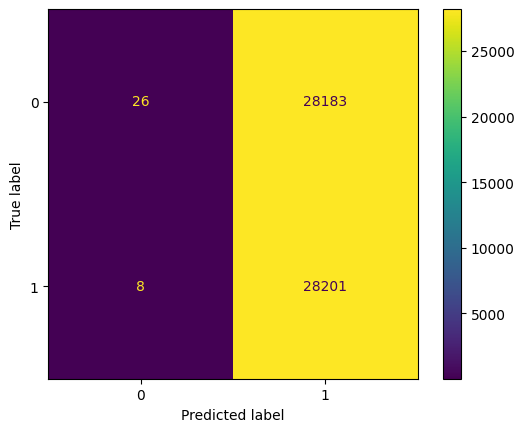

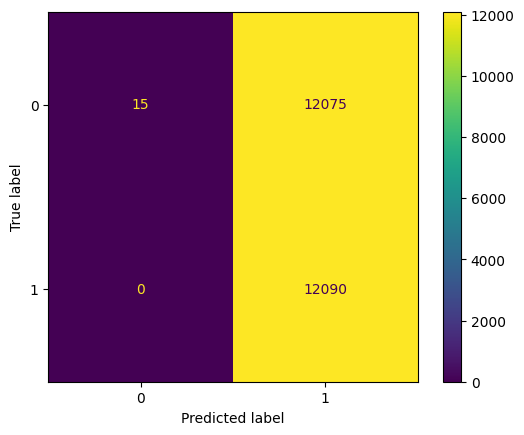

In [ ]:

lr = LogisticRegression(max_iter= 50000  , solver="liblinear")
lr.fit(feature_train_ros,feature_test_ros)
lr_train = lr.predict(feature_train_ros)
ConfusionMatrixDisplay.from_predictions(feature_test_ros,lr_train)
print("train",f1_score(feature_test_ros,lr_train) ,accuracy_score(feature_test_ros,lr_train))
lr_test = lr.predict(target_train_ros)
ConfusionMatrixDisplay.from_predictions(target_test_ros,lr_test)
f1_score(target_test_ros,lr_test) , accuracy_score(target_test_ros,lr_test)

([<matplotlib.lines.Line2D at 0x7ef1785355a0>], 0.500620347394541)

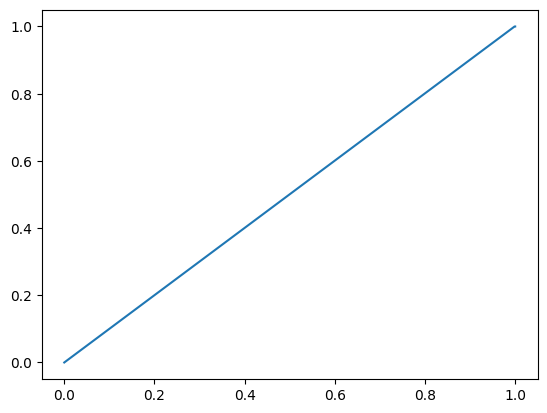

In [ ]:
from sklearn import metrics
false , positve , thesold =  metrics.roc_curve(target_test_ros , lr_test)
plt.plot(false,positve) ,metrics.auc(false , positve)

## Re-Training the model

In [ ]:
#improving model performance
corr_relation = pd.concat([feature_train_ros,feature_test_ros] , axis = 1)
corr_relation.cov()

,travel_type_id,from_area_id,to_area_id,online_booking,mobile_site_booking,Duration,from_date_day,from_date_month,from_date_weekday,booking_created_day,booking_created_month,booking_created_weekday,distance,Car_Cancellation
travel_type_id,1.492223e-01,5.748501e-01,-3.204931e+01,-1.392797e-02,-2.877913e-03,-1.294695e+13,2.378017e-02,-2.191210e-02,2.888140e-02,-5.001829e-02,-1.467662e-02,4.527708e-02,1.530288e+00,-1.184927e-02
from_area_id,5.748501e-01,1.849222e+05,5.330759e+03,6.963785e+00,-3.056015e+00,2.694695e+15,4.617669e+01,2.854534e+01,-5.228810e+00,7.413994e+01,2.669335e+01,-1.096278e+01,-3.950634e+02,5.756270e+00
to_area_id,-3.204931e+01,5.330759e+03,1.606798e+05,1.517171e+01,5.771868e-01,6.742058e+15,2.045171e+01,5.826340e+01,-3.028961e+01,5.689421e+01,5.499061e+01,-1.942355e+01,-1.244654e+03,3.192672e+01
online_booking,-1.392797e-02,6.963785e+00,1.517171e+01,2.492795e-01,-3.120187e-02,-3.480750e+13,-2.417268e-01,1.654893e-01,8.155634e-02,-2.475248e-01,1.788991e-01,5.191584e-02,-6.666471e-02,6.925218e-02
mobile_site_booking,-2.877913e-03,-3.056015e+00,5.771868e-01,-3.120187e-02,6.160527e-02,-6.031601e+12,-3.045136e-02,6.094225e-02,1.204695e-02,-5.420807e-02,6.407313e-02,1.506266e-02,-5.456732e-02,1.324955e-02
Duration,-1.294695e+13,2.694695e+15,6.742058e+15,-3.480750e+13,-6.031601e+12,1.565621e+29,5.508310e+14,2.484761e+14,-6.330170e+13,7.807501e+14,1.857221e+14,-3.512046e+13,-4.879144e+14,8.737707e+12
from_date_day,2.378017e-02,4.617669e+01,2.045171e+01,-2.417268e-01,-3.045136e-02,5.508310e+14,7.523113e+01,-8.531315e-01,-4.912327e-01,6.244196e+01,-6.484295e-01,-3.595935e-01,-1.579533e+00,-1.397362e-01
from_date_month,-2.191210e-02,2.854534e+01,5.826340e+01,1.654893e-01,6.094225e-02,2.484761e+14,-8.531315e-01,8.384092e+00,-3.644910e-01,3.299518e-01,8.247094e+00,-2.597507e-01,-1.428312e+00,3.685503e-01
from_date_weekday,2.888140e-02,-5.228810e+00,-3.028961e+01,8.155634e-02,1.204695e-02,-6.330170e+13,-4.912327e-01,-3.644910e-01,4.095671e+00,-5.393073e-01,-3.369247e-01,2.485127e+00,1.176901e+00,4.597905e-02
booking_created_day,-5.001829e-02,7.413994e+01,5.689421e+01,-2.475248e-01,-5.420807e-02,7.807501e+14,6.244196e+01,3.299518e-01,-5.393073e-01,8.134639e+01,-5.814892e-01,-2.788824e-01,-2.375919e+00,3.899534e-02


## Feature Selecion

In [ ]:
modified_feature_train = corr_relation.copy()
modified_target_train = target_train_ros.copy()
modified_feature_train.drop( ["distance","travel_type_id", "from_date_day"  ,"from_area_id" , "booking_created_day","from_date_weekday","booking_created_weekday" , "Duration","Car_Cancellation" ] ,axis =1 ,inplace = True)
modified_target_train.drop(["distance","travel_type_id", "from_date_day" , "from_area_id" , "booking_created_day","from_date_weekday","booking_created_weekday" ,"Duration"], axis =1 , inplace = True)

modified_target_train.shape , modified_feature_train.shape

modified_feature_train.corr()

,to_area_id,online_booking,mobile_site_booking,from_date_month,booking_created_month
to_area_id,1.000000,0.075807,0.005801,0.050198,0.047976
online_booking,0.075807,1.000000,-0.251784,0.114472,0.125309
mobile_site_booking,0.005801,-0.251784,1.000000,0.084797,0.090278
from_date_month,0.050198,0.114472,0.084797,1.000000,0.996069
booking_created_month,0.047976,0.125309,0.090278,0.996069,1.000000


# LogisticRegression and Validating the model on train and test set

train 0.6980663503862161 0.687528802864334


(0.693359217018523, 0.686435070306038)

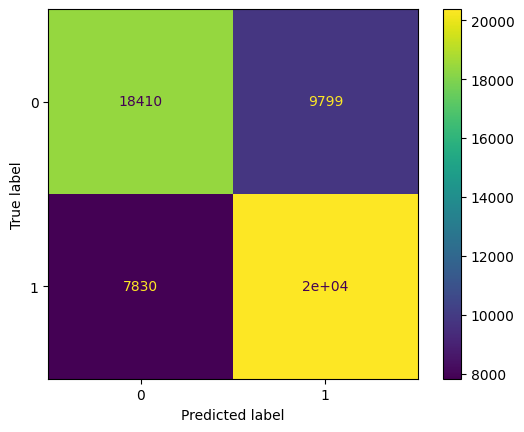

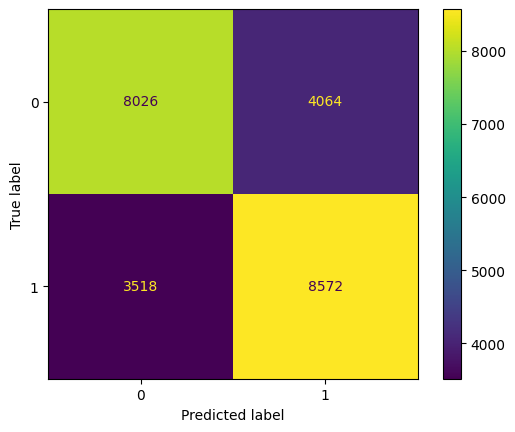

In [ ]:

m_lr = LogisticRegression(max_iter =5000 )
m_lr.fit(modified_feature_train,feature_test_ros)
m_lr_train = m_lr.predict(modified_feature_train)
ConfusionMatrixDisplay.from_predictions(feature_test_ros,m_lr_train)
print("train",f1_score(feature_test_ros,m_lr_train) ,accuracy_score(feature_test_ros,m_lr_train))

m_lr_test = m_lr.predict(modified_target_train)
ConfusionMatrixDisplay.from_predictions(target_test_ros,m_lr_test)
f1_score(target_test_ros,m_lr_test) , accuracy_score(target_test_ros,m_lr_test)

In [ ]:
pd.DataFrame(lr.coef_ ,  columns=feature_train_ros.columns)


,travel_type_id,from_area_id,to_area_id,online_booking,mobile_site_booking,Duration,from_date_day,from_date_month,from_date_weekday,booking_created_day,booking_created_month,booking_created_weekday,distance
0,-8.542960e-31,1.790935e-28,1.462020e-27,3.368903e-30,6.471312e-31,2.120357e-16,-9.650513e-30,1.673885e-29,1.893364e-30,-1.262711e-30,1.645351e-29,2.684666e-30,-7.072734e-29


# DecisionTree and Validating the model on train and test set

train 0.8078572175549901 0.8046013683576163


(0.7546321814712741, 0.7606699751861042)

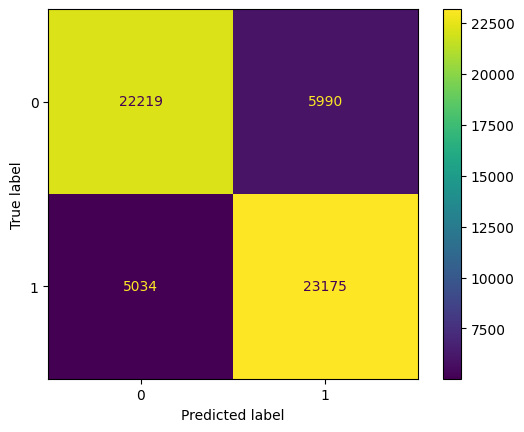

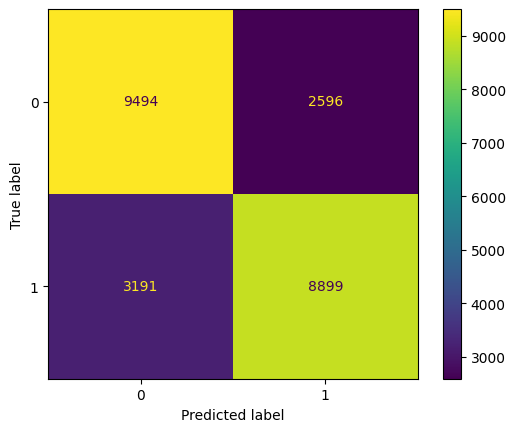

In [ ]:

dtc = DecisionTreeClassifier(max_depth = 8)
dtc.fit(feature_train_ros,feature_test_ros)
dtc_train = dtc.predict(feature_train_ros)
ConfusionMatrixDisplay.from_predictions(feature_test_ros,dtc_train)
print("train",f1_score(feature_test_ros,dtc_train) , accuracy_score(feature_test_ros,dtc_train))


dtc_test = dtc.predict(target_train_ros)
ConfusionMatrixDisplay.from_predictions(target_test_ros,dtc_test)
f1_score(target_test_ros,dtc_test) , accuracy_score(target_test_ros,dtc_test)

# KNeighboreClassifier

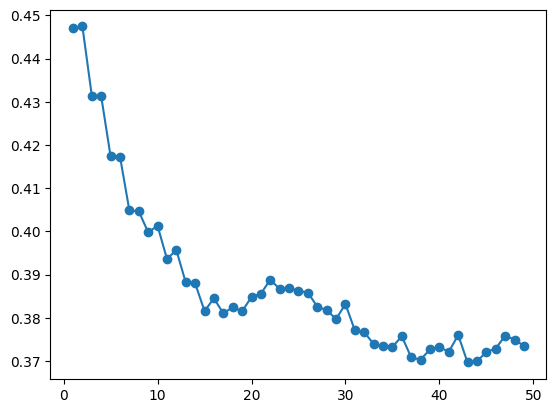

In [ ]:
errors = []
for i in range(1,50):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(feature_train_ros,feature_test_ros)
  knn_train = knn.predict(target_train_ros)
  errors.append(np.mean(knn_train != np.array(target_test_ros)))
plt.plot(range(1,50) , errors , marker = 'o')

# Validating the model on train and test set

train 0.820335980258787 0.798681271934489


(0.5948810754912099, 0.611166253101737)

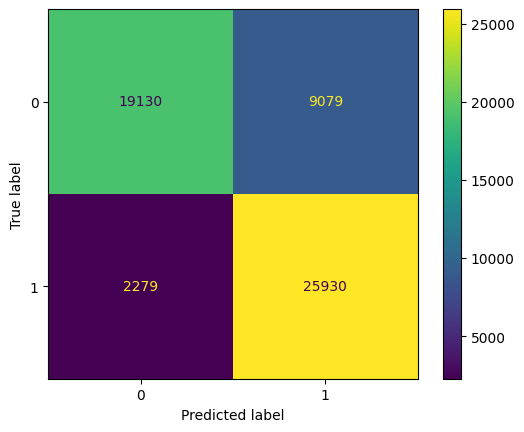

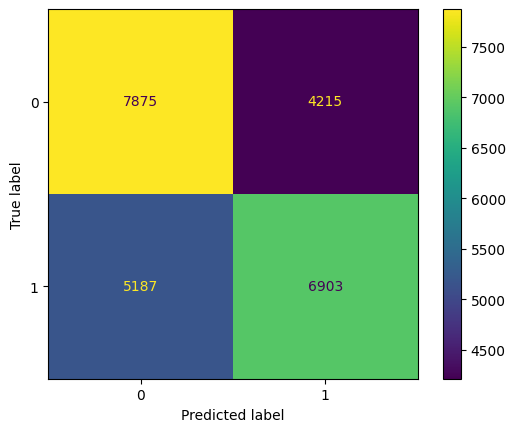

In [ ]:

knn = KNeighborsClassifier(n_neighbors=22 , p =2)
knn.fit(feature_train_ros,feature_test_ros)
knn_train = knn.predict(feature_train_ros)
ConfusionMatrixDisplay.from_predictions(feature_test_ros,knn_train)
print("train",f1_score(feature_test_ros,knn_train) , accuracy_score(feature_test_ros,knn_train))


knn_test = knn.predict(target_train_ros)
ConfusionMatrixDisplay.from_predictions(target_test_ros,knn_test)
f1_score(target_test_ros,knn_test) , accuracy_score(target_test_ros,knn_test)


# RandomForestClassifier and Validating the model on train and test set

train 0.8252024561715761 0.825924350384629


(0.7605117233550189, 0.7731596360628619)

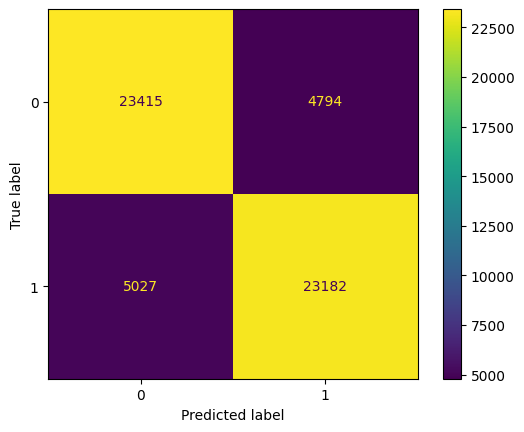

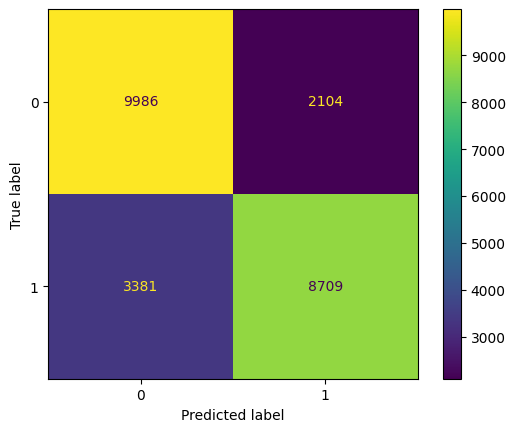

In [ ]:


rfc = RandomForestClassifier(n_estimators = 200 , max_depth = 8  ,min_samples_split = 30 )
rfc.fit(feature_train_ros,feature_test_ros)
rfc_train = rfc.predict(feature_train_ros)
ConfusionMatrixDisplay.from_predictions(feature_test_ros,rfc_train)
print("train",f1_score(feature_test_ros,rfc_train) , accuracy_score(feature_test_ros,rfc_train))


rfc_test = rfc.predict(target_train_ros)
ConfusionMatrixDisplay.from_predictions(target_test_ros,rfc_test)
f1_score(target_test_ros,rfc_test) , accuracy_score(target_test_ros,rfc_test)


In [ ]:
with open("/content/drive/MyDrive/Projects/predicting_cab/rfc.pickle","wb") as f:
  pickle.dump(rfc , f)


# HyperParameter Tuning


In [ ]:
rf = RandomForestClassifier()

params_gscv = {
    "n_estimators" : [150,200],
    "max_depth" : [8,10,None],
    "min_samples_split" : [20,30,40],
    "max_features":["sqrt", 0.5],
    "n_jobs": [-1],

}

gscv = GridSearchCV(
    estimator =  rf,
    param_grid = params_gscv,
    scoring = 'f1',
    cv = 5,
    return_train_score = True
)

gscv.fit(feature_train_ros,feature_test_ros)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 10, None],
                         'max_features': ['sqrt', 0.5],
                         'min_samples_split': [20, 30, 40],
                         'n_estimators': [150, 200], 'n_jobs': [-1]},
             return_train_score=True, scoring='f1')

In [ ]:
with open("/content/drive/MyDrive/Projects/predicting_cab/GirdSearchCV.pickle","wb") as f:
  pickle.dump(gscv , f)


In [ ]:
with open("/content/drive/MyDrive/Projects/predicting_cab/GirdSearchCV.pickle","rb") as f:
  gscv = pickle.load(f )

In [ ]:
result = pd.DataFrame({
    "params" : gscv.cv_results_["params"],
    "MeanTrainScore" : gscv.cv_results_["mean_train_score"],
    "MeanTestScore" : gscv.cv_results_["mean_test_score"]

})

In [ ]:
result.to_csv("GridSearchResult.csv" , index = None)

In [ ]:
result.head()

,params,MeanTrainScore,MeanTestScore
0,"{'max_depth': 8, 'max_features': 'sqrt', 'min_...",0.825858,0.819149
1,"{'max_depth': 8, 'max_features': 'sqrt', 'min_...",0.824800,0.818577
2,"{'max_depth': 8, 'max_features': 'sqrt', 'min_...",0.823439,0.816778
3,"{'max_depth': 8, 'max_features': 'sqrt', 'min_...",0.823599,0.817084
4,"{'max_depth': 8, 'max_features': 'sqrt', 'min_...",0.823684,0.817053


# I Get best result after HyperParameter tuning

###### {'max_features': 0.5, 'min_samples_split': 20, 'n_estimators': 150, 'n_jobs': -1}
######  MeanTrainScore = 0.99169691319115
######  MeanTestScore = 0.974443534783147


train 0.9947106738601502 0.9946825481229394


(0.566001140901312, 0.6853598014888338)

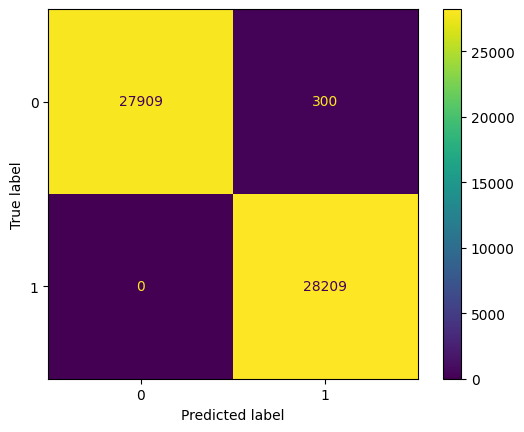

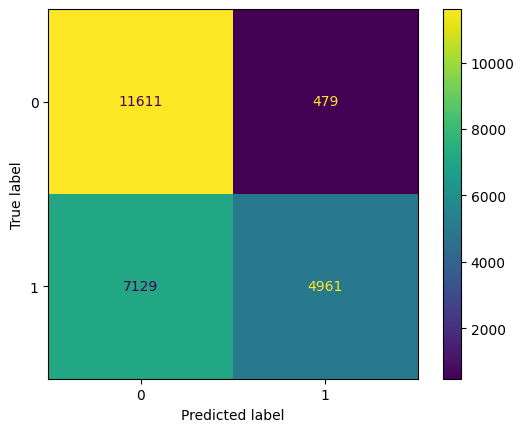

In [ ]:
#### validation accuracy not good it is overfit model

rfc = RandomForestClassifier(n_estimators = 150 , max_features = 0.5 ,min_samples_split = 20 )
rfc.fit(feature_train_ros,feature_test_ros)
rfc_train = rfc.predict(feature_train_ros)
ConfusionMatrixDisplay.from_predictions(feature_test_ros,rfc_train)
print("train",f1_score(feature_test_ros,rfc_train) , accuracy_score(feature_test_ros,rfc_train))


rfc_test = rfc.predict(target_train_ros)
ConfusionMatrixDisplay.from_predictions(target_test_ros,rfc_test)
f1_score(target_test_ros,rfc_test) , accuracy_score(target_test_ros,rfc_test)


train 0.8230839301980816 0.8244354638590521


(0.7549622343228526, 0.7692307692307693)

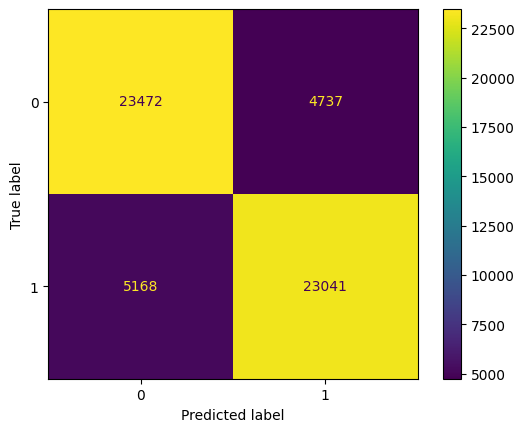

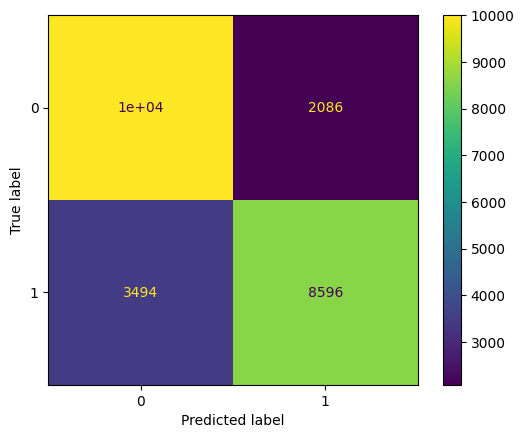

In [ ]:
#{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 40, 'n_estimators': 200, 'n_jobs': -1}

rfc = RandomForestClassifier(n_estimators = 200 , max_depth = 8  ,min_samples_split = 40  , max_features = "sqrt")
rfc.fit(feature_train_ros,feature_test_ros)
rfc_train = rfc.predict(feature_train_ros)
ConfusionMatrixDisplay.from_predictions(feature_test_ros,rfc_train)
print("train",f1_score(feature_test_ros,rfc_train) , accuracy_score(feature_test_ros,rfc_train))


rfc_test = rfc.predict(target_train_ros)
ConfusionMatrixDisplay.from_predictions(target_test_ros,rfc_test)
f1_score(target_test_ros,rfc_test) , accuracy_score(target_test_ros,rfc_test)


# HistGradientBoostingClassifier

train 0.8486514703323473 0.8458293452444255


(0.7825491287408486, 0.7899503722084368)

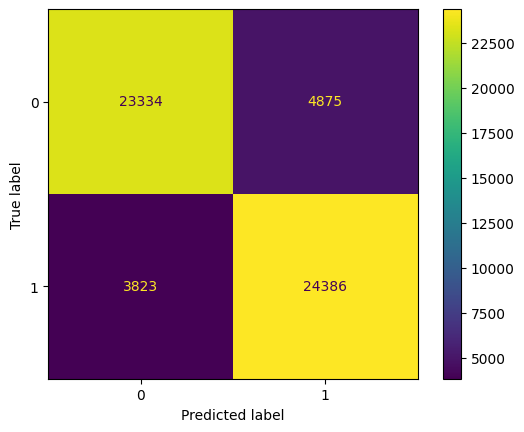

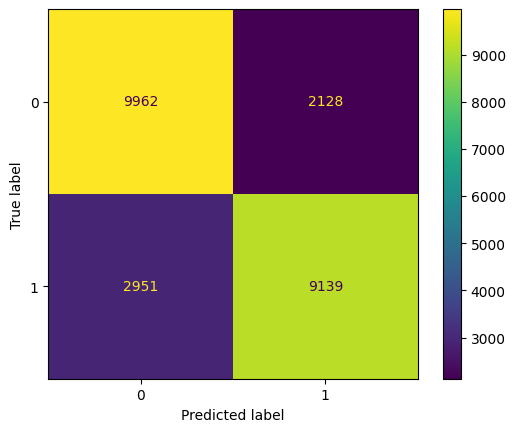

In [ ]:
hgbc = HistGradientBoostingClassifier(learning_rate = 0.1 , max_iter = 200 ,max_depth = 8 , max_leaf_nodes = 10)
hgbc.fit(feature_train_ros,feature_test_ros)
hgbc_train = hgbc.predict(feature_train_ros)
ConfusionMatrixDisplay.from_predictions(feature_test_ros,hgbc_train)
print("train",f1_score(feature_test_ros,hgbc_train) , accuracy_score(feature_test_ros,hgbc_train))


hgbc_test = hgbc.predict(target_train_ros)
ConfusionMatrixDisplay.from_predictions(target_test_ros,hgbc_test)
f1_score(target_test_ros,hgbc_test) , accuracy_score(target_test_ros,hgbc_test)


In [ ]:
with open("/content/drive/MyDrive/Projects/predicting_cab/hgbc.pickle","wb") as f:
  pickle.dump(hgbc , f)
